In [1]:
import pandas as pd
from cif_site_analyzer.utilities import _parse_formula
from collections import defaultdict
import numpy as np
import ast
from cif_site_analyzer.cif_reader import read_cif
from matplotlib import pyplot as plt
import os

In [2]:
def parse(form):
    try:
        form = dict(_parse_formula(form))
        for k, _ in form.items():
            if k in ["Ac", "Pa", "Np", "Pu", "Am", "Cm", "Bk", "Cf", "Es", "Fm", "Md", "No", "Lr",
                     "H", "D", "T", "He", "Ne", "Ar", "Kr", "Xe", "Rn",
                     "F", "Cl", "Br", "I", "At",
                     "O", "S", "N", "C"] or "x" in k:
                return -1
        return form
    except:
        return -1

In [3]:
def is_AB2(pf):
    form = ast.literal_eval(str(pf))
    coefs = sorted([v for _, v in form.items()])

    total = sum(coefs)
    coefs = [c/total for c in coefs]

    if len(coefs) == 3:
        for i in range(3):
            if 0.33 <= coefs[i] <= 0.34:
                return 1
    elif len(coefs) == 2:
        if 0.33 < min(coefs) < 0.34:
            return 1
    return 0

In [4]:
def get_ABs(pf):
    pf = ast.literal_eval(str(pf))
    ABs = []

    total = sum(pf.values())
    for e, c in pf.items():
        if 0.32 <= c/total <= 0.34:
            A = e
            Bs = '-'.join(sorted([e for e in pf.keys() if e != A], key=lambda k: mns[k]))

            ABs.append(f"{A}_{Bs}")
    
    if len(ABs):
        return ABs

In [5]:
def has_A(pf, el):
    form = ast.literal_eval(str(pf))
    A_ok = 0
    Bs = ""
    d = -1
    if el in form:
        if 0.33 <= form[el]/sum(form.values()) <= 0.34:
            A_ok = 1
            Bs = '-'.join(sorted([e for e in form.keys() if e != el]))
            total = sum(form.values())
            coefs = [c/total for e, c in form.items() if e != el]
            d = round(max(coefs) - min(coefs), 2)

    return A_ok, Bs, d

In [6]:
def get_latex_formula(formula):
    try:
        formula = formula.split()
        cond = None
        if len(formula) > 1:
            cond = ' '.join(formula[1:])
        
        formula = formula[0]
        adds = None
        if '-' in formula:
            ind = formula.index('-')
            adds = formula[ind:]
            formula = formula[:ind]

        pf = _parse_formula(formula)
        lformula = "$\mathrm{"
        for e, c in pf.items():
            if 1 - 1e-3 <= float(c) <= 1 + 1e-3:
                lformula += f"{e}"
            elif abs(float(c) - int(c)) < 1e-3:
                lformula += f"{e}_" + "{" + f"{c:.0f}" + "}"
            else:
                lformula += f"{e}_" + "{" + f"{c:.2f}" + "}"

        lformula += "}$" 

        if adds:
            lformula += f"{adds}"
        
        if cond:
            lformula += f" {cond}"
        return lformula
    except:
        print(formula)
        return formula

<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_33741/3781414988.py:16: SyntaxWarning: invalid escape sequence '\m'
  lformula = "$\mathrm{"


In [7]:
def plot_sol(tdf, A, elements_sorted, filename, plot=True):
    tdf.drop_duplicates("Formula", inplace=True)
    tdf = tdf[tdf["is_AB2"]==1]
    tdf = tdf[tdf["Entry prototype"] != "prototype?"]
    data = []

    ends = [False, False]
    end_stypes = ["", ""]
    more_than_one_at_end = False

    for _, row in tdf.iterrows():
        stype = row["Entry prototype"].split(",")[0]
        # if stype not in ["AlB2", "MgZn2", "MgCu2"]:
        #     continue
        pf = ast.literal_eval(str(row["pf"]))
        total = sum(pf.values())
        form_B = [[k, pf.get(elements_sorted[0], 0.0), pf.get(elements_sorted[1], 0.0)] for k, v in pf.items()if k != A]
        
        cond = row["Formula (phase)"].split()
        icond = 0
        if len(cond) > 1:
            cond = " ".join(cond[1:]).strip()
            if cond == "rt":
                icond = 0
            else:
                icond = -2


        # assert len(form_B) == 2
        form_B = sorted(form_B, key=lambda x: float(x[0] == elements_sorted[0]), reverse=False)
        # print("formB", form_B)
        if len(form_B) == 1:
            for i, v in enumerate(form_B[0][1:]):
                if v != 0:
                    ends[i] = stype in ["AlB2", "MgZn2", "MgCu2"]
                    end_stypes[i] = stype
        if icond == 0:
            data.append([round(form_B[0][1]/total, 2), icond, get_latex_formula(row['Formula']), row['Entry prototype'], row['pf'], row['Formula (phase)']])
        else:
            data.append([round(form_B[0][1]/total, 2), icond, get_latex_formula(row['Formula (phase)']), row['Entry prototype'], row['pf'], row['Formula (phase)']])
    # print([[d[i] for i in [0, -1, -3]] for d in data])
    data = sorted(data, key=lambda x: x[0])
    # print([[d[i] for i in [0, -1, -3]] for d in data])

    counts = [d[0] for d in data]
    if counts.count(0.0) > 1 or counts.count(1.0) > 1:
        more_than_one_at_end = True
    
    if all(ends):
        if plot:
            directory = '-'.join(sorted(end_stypes))
            plt.plot([0, 1], [0, 0], c='k')
            if any([d[1]==-2 for d in data]):
                plt.plot([0, 1], [-0.2, -0.2], ls="--", c='k')
            for x, icond, form, ptype, _, _ in data:
                ptype = get_latex_formula(ptype.split(',')[0])
                x = x/0.67
                if icond == 0:
                    y = icond
                    plt.scatter(x, y, c='orange')
                    plt.text(x, y, s=f"{ptype} ({form})", rotation=90,          # or 'vertical'
                    ha="center", va="bottom")
                else:
                    y = -0.2
                    plt.scatter(x, y, c='orange')
                    plt.text(x, y, s=f"{ptype} ({form})", rotation=270,          # or 'vertical'
                    ha="center", va="top")
            plt.axis("off")
            plt.xlim(-0.05, 1.05)
            plt.ylim(-2, 2)
            plt.tight_layout()
            plt.show()

            plt.savefig(f"{filename}.png", dpi=300);
            # if more_than_one_at_end:
            #     plt.savefig(f"comp/images/m_{directory}/{filename}.png", dpi=300);
            # else:
            #     plt.savefig(f"comp/images/{directory}/{filename}.png", dpi=300);
            # tdf[["Entry", "Formula (phase)", "Entry prototype"]].to_csv(f"comp/{A}/csv/{filename}.csv")
            plt.close()
        return 1, data, more_than_one_at_end
    return 0, None, more_than_one_at_end

In [8]:
df = pd.read_csv("All_in_PCD_2025.csv")
dfp = pd.read_csv("PCD_All_Phase_form.csv", encoding="latin")

df = df.merge(dfp[['Entry', 'Formula (phase)']], on='Entry', how='left')
df.head()

,Formula,Entry prototype,SGR symbol (std.),SGR no. (std.),a [nm],b [nm],c [nm],Journal,Reference,Level struct. studies,Entry,Formula (phase)
0,Ac,"Cu,cF4,225",Fm-3m,225.0,0.5311,0.5311,0.5311,JINCAO,"(1961) 18, 42-47",cell parameters determined and type with fixed...,535139,Ac
1,AcBr3,"UCl3,hP8,176",P63/m,176.0,0.8060,0.8060,0.4680,JCPSA6,"(1948) 16, 254",cell parameters determined and structure type ...,1812253,AcBr3
2,AcBr3,"UCl3,hP8,176",P63/m,176.0,0.8080,0.8080,0.4690,ACCRA9,"(1948) 1, 265-268",cell parameters determined and structure type ...,451069,AcBr3
3,AcBrO,"PbClF,tP6,129",P4/nmm O2,129.0,0.4280,0.4280,0.7410,ACCRA9,"(1949) 2, 388-390",cell parameters determined and structure type ...,1502353,AcBrO
4,AcCl3,"UCl3,hP8,176",P63/m,176.0,0.7640,0.7640,0.4560,JINCAO,"(1968) 30, 823-828",cell parameters determined and structure type ...,559855,AcCl3


In [9]:
df["pf"] = df["Formula"].map(parse)

In [10]:
print(len(df[df["pf"]==-1]), len(df))
df = df[df["pf"]!=-1]

289165 409771


In [11]:
df["num_elem"] = df["pf"].map(lambda r: len(ast.literal_eval(str(r))))
df["num_elem"].value_counts()

num_elem
3     63206
2     40770
4     12054
1      3235
5      1022
6       218
7        60
8        27
9        10
10        4
Name: count, dtype: int64

In [12]:
df = df[df["num_elem"].isin([2, 3])]

In [13]:
df["is_AB2"] = df["pf"].map(is_AB2)
df["is_AB2"].value_counts()

is_AB2
0    80665
1    23311
Name: count, dtype: int64

In [14]:
df = df[df["is_AB2"] == 1]

In [15]:
df["elements"] = df["pf"].map(lambda x: list(ast.literal_eval(str(x)).keys()))

In [16]:
df[["Ce", "Ce_Bs", "Ce_d"]] = df.apply(lambda r: has_A(r["pf"], "Ce"), axis=1, result_type="expand")
df["Ce"].value_counts()

Ce
0    22130
1     1181
Name: count, dtype: int64

In [17]:
tdf = df[(df["Ce"] == 1) & (df["Ce_Bs"].isin(["Co-Ga", "Ga", "Co"]))]

/tmp/ipykernel_33741/660070736.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf.drop_duplicates("Formula", inplace=True)


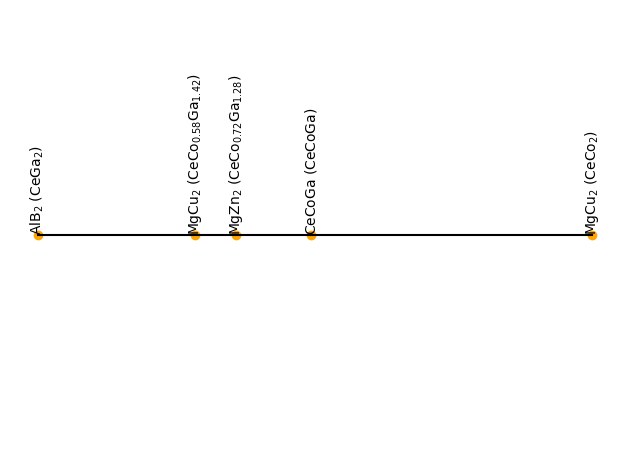

(1,
 [[0.0,
   0,
   '$\\mathrm{CeGa_{2}}$',
   'AlB2,hP3,191',
   {'Ce': 1.0, 'Ga': 2.0},
   'CeGa2'],
  [0.19,
   0,
   '$\\mathrm{CeCo_{0.58}Ga_{1.42}}$',
   'MgCu2,cF24,227',
   {'Ce': 1.0, 'Co': 0.58, 'Ga': 1.42},
   'CeCo0.58Ga1.42'],
  [0.24,
   0,
   '$\\mathrm{CeCo_{0.72}Ga_{1.28}}$',
   'MgZn2,hP12,194',
   {'Ce': 1.0, 'Co': 0.72, 'Ga': 1.28},
   'CeCo0.72Ga1.28'],
  [0.33,
   0,
   '$\\mathrm{CeCoGa}$',
   'CeCoGa,mS36,12',
   {'Ce': 1.0, 'Co': 1.0, 'Ga': 1.0},
   'CeCoGa rt'],
  [0.67,
   0,
   '$\\mathrm{CeCo_{2}}$',
   'MgCu2,cF24,227',
   {'Ce': 1.0, 'Co': 2.0},
   'CeCo2']],
 False)

In [18]:
plot_sol(tdf, "Ce", ["Co", "Ga"], filename="test")